
# $$SVD$$
## $$on$$
# $$MNIST-Dataset$$

In [1]:
# Importing libraries
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [2]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Function that creates a dictionary with levels as keys and images as values for both training and testing purpose
def matrix_with_n_images_per_label(n, train):

  # Create a dictionary to store images for each label
  images_by_label = {}
  test_set = {}
  for label in range(10):
    images_by_label[label] = train[train_labels == label][:n]
    test_set[label] = train[train_labels == label][n:]

  # Create a matrix for each label
  matrices_by_label = {}
  test_set_label = {}
  for label, images in images_by_label.items():
    matrices_by_label[label] = np.hstack([image.flatten()[:, np.newaxis] for image in images])
  for label, images in test_set.items():
    test_set_label[label] = np.hstack([image.flatten()[:, np.newaxis] for image in images])

  return matrices_by_label, test_set_label

In [4]:
# creating the model using the first 3000 datapoints for each label
n = 3000
image_label_matrix, test_matrix = matrix_with_n_images_per_label(n, train_images)

In [5]:
# Function to find the first n left singular values
def extract_left_singular_vectors(matrix_by_label, first_n_vect):
  left_singular_vectors_by_label = {}
  for label, matrix in matrix_by_label.items():
    u,s, v = np.linalg.svd(matrix)
    left_singular_vectors_by_label[label] = u[:, :first_n_vect]
  return left_singular_vectors_by_label



In [6]:
no_of_sv = 4
left_singular_vectors_by_label = extract_left_singular_vectors(image_label_matrix, no_of_sv)

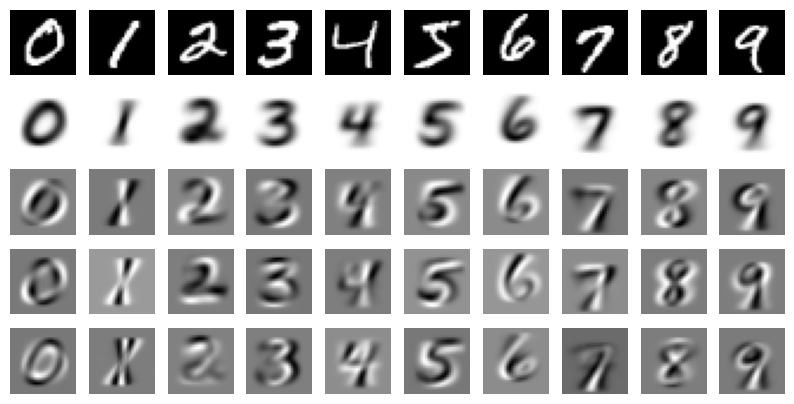

In [7]:
# Select the first image for each digit
first_images_by_label = {}
for label in range(10):
  first_images_by_label[label] = train_images[train_labels == label][0]


plt.figure(figsize=(10, 5))
for i in range(10):
  plt.subplot(5, 10, i + 1)

  plt.imshow(first_images_by_label[i], cmap='gray')
  plt.axis('off')
  for j in range(4):
    plt.subplot(5, 10, i + 1 + (j + 1) * 10)
    plt.imshow(left_singular_vectors_by_label[i][:, j].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()


The first row contains the original image. The next 4 rows are created using the first 4 left singular vectors.

For the classification purpose, we are finding the matrix D(n) for which the value of  
$||D(n)x - z||_2$, is least, n = 0, 1, 2,...., 9.

So, we first project the test vector z onto the column space of D(n). As D(n) is not full rank, we take a low rank approximation of D(n) and project the images onto it. Here, we are using the first 4 left singular vectors for the low-rank approximation.
For the projection purpose, we used the formula: $$u_i.u_i^T.z$$

In [8]:
# Function that classifies images based on the first 4 SVDs
def classify_image(test_vector, left_singular_vectors_by_label):

  # Compute the reconstruction error for each label
  reconstruction_errors = {}
  for label, vectors in left_singular_vectors_by_label.items():
    # Project the test image onto the left singular vectors
    projected_image = vectors.T @ test_vector
    # Reconstruct the image using the projection
    reconstructed_image = vectors @ projected_image
    # Compute the reconstruction error
    reconstruction_errors[label] = np.linalg.norm(test_vector - reconstructed_image)

  # Find the label with the smallest reconstruction error
  predicted_label = min(reconstruction_errors, key=reconstruction_errors.get)

  return predicted_label

In [9]:
predicted_label = []
actual_label = []
for i in range(10):

  no_of_test_images = len(test_matrix[i][1])
  for images in range(no_of_test_images):
    actual_label.append(i)
    pred = classify_image(np.array(test_matrix[i][:, images]), left_singular_vectors_by_label)
    predicted_label.append(pred)


In [10]:
# Evaluate the classification accuracy
accuracy = (np.sum(np.array(predicted_label) == actual_label) / len(actual_label))*100
print(f"Classification accuracy is {accuracy}%")

Classification accuracy is 91.69333333333334%


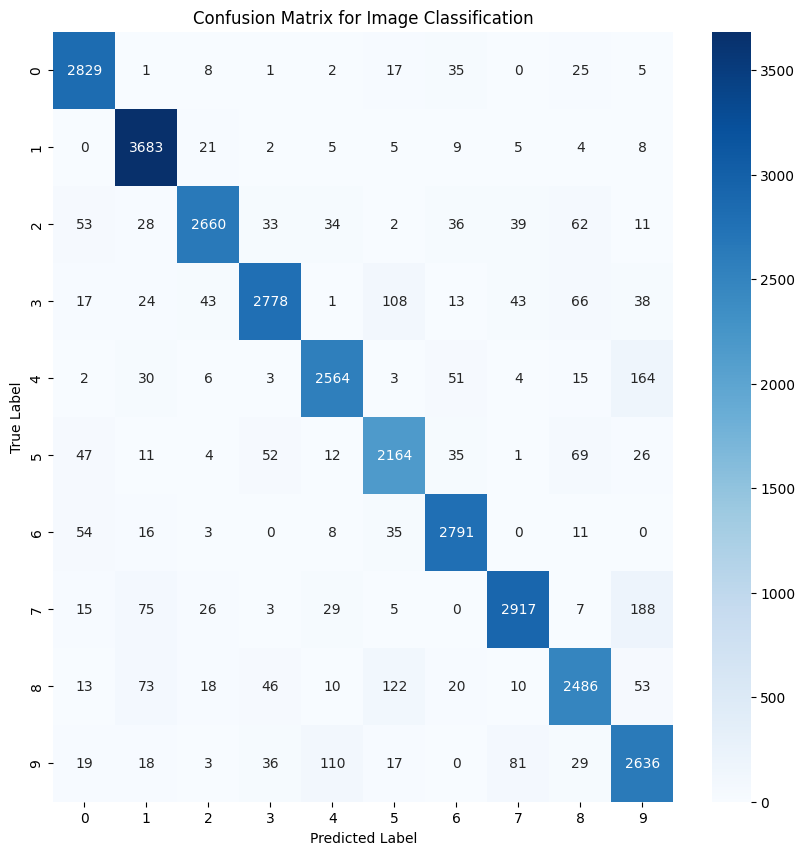

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create the confusion matrix
confusion_matrix = confusion_matrix(actual_label, predicted_label)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Image Classification")
plt.show()
